# Ames Housing Dataset - Preprocessing

**Dataset**: Ames Housing (Iowa, USA)  
**Source**: OpenML  
**Target**: SalePrice (house sale price)

## Key Points - No Data Leakage
1. Train/test split BEFORE any preprocessing
2. Fit transformers on TRAIN data only
3. Transform test data using train statistics


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
print("Libraries loaded!")


Libraries loaded!


In [14]:
# Define paths
DATA_DIR = Path('../data')
PROCESSED_DIR = DATA_DIR / 'processed'
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

print(f"Data directory: {DATA_DIR.resolve()}")


Data directory: /Users/julianhardt/Library/Mobile Documents/com~apple~CloudDocs/Datascience/5.Semester/Machine Learning/excercise_2/ml-exercise2/ml_implementation/data


## 1. Load Dataset


In [15]:
# Load Ames Housing from OpenML
print("Loading Ames Housing from OpenML...")
ames = fetch_openml(name="house_prices", as_frame=True, parser='auto')
df = ames.frame

print(f"Dataset loaded: {df.shape[0]} samples, {df.shape[1]} columns")
print(f"\nColumn types:")
print(df.dtypes.value_counts())


Loading Ames Housing from OpenML...
Dataset loaded: 1460 samples, 81 columns

Column types:
object     43
int64      35
float64     3
Name: count, dtype: int64


## 2. Exploratory Data Analysis


Target: SalePrice
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


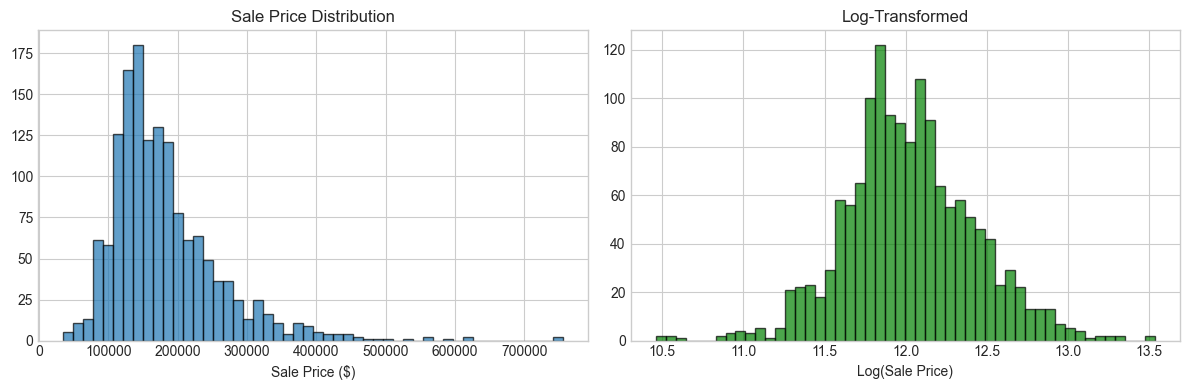

In [16]:
# Target: SalePrice
TARGET = 'SalePrice'

print(f"Target: {TARGET}")
print(df[TARGET].describe())

# Distribution plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(df[TARGET], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Sale Price ($)')
axes[0].set_title('Sale Price Distribution')

axes[1].hist(np.log1p(df[TARGET]), bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Log(Sale Price)')
axes[1].set_title('Log-Transformed')
plt.tight_layout()
plt.show()


In [17]:
# Missing values
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Missing': missing, 'Percent': missing_pct})
missing_df = missing_df[missing_df['Missing'] > 0].sort_values('Missing', ascending=False)

print(f"Columns with missing values: {len(missing_df)}")
print(missing_df.head(10))


Columns with missing values: 19
              Missing  Percent
PoolQC           1453    99.52
MiscFeature      1406    96.30
Alley            1369    93.77
Fence            1179    80.75
FireplaceQu       690    47.26
LotFrontage       259    17.74
GarageType         81     5.55
GarageYrBlt        81     5.55
GarageFinish       81     5.55
GarageQual         81     5.55


In [18]:
# Identify column types
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

if TARGET in numeric_cols:
    numeric_cols.remove(TARGET)
if 'Id' in numeric_cols:
    numeric_cols.remove('Id')

print(f"Numeric features: {len(numeric_cols)}")
print(f"Categorical features: {len(categorical_cols)}")

# Top correlations
corr_with_target = df[numeric_cols + [TARGET]].corr()[TARGET].drop(TARGET).abs().sort_values(ascending=False)
print(f"\nTop 5 correlations with {TARGET}:")
for feat, corr in corr_with_target.head(5).items():
    print(f"  {feat}: {corr:.3f}")


Numeric features: 36
Categorical features: 43

Top 5 correlations with SalePrice:
  OverallQual: 0.791
  GrLivArea: 0.709
  GarageCars: 0.640
  GarageArea: 0.623
  TotalBsmtSF: 0.614


## 3. Train/Test Split FIRST (No Data Leakage)

**Critical**: Split before any preprocessing to prevent information from test set leaking into training.


In [19]:
# Separate features and target
X = df.drop([TARGET, 'Id'], axis=1, errors='ignore')
y = df[TARGET].values.astype(np.float64)

# Split BEFORE preprocessing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train: {X_train.shape[0]} samples")
print(f"Test: {X_test.shape[0]} samples")


Train: 1168 samples
Test: 292 samples


## 4. Preprocessing (Fit on Train Only)


In [20]:
# Recalculate column types after split
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numeric: {len(numeric_cols)}, Categorical: {len(categorical_cols)}")

# Store preprocessing statistics from TRAIN set only
train_stats = {}

# Numeric: medians from TRAIN
for col in numeric_cols:
    train_stats[col] = {'median': X_train[col].median()}

# Categorical: modes and categories from TRAIN
for col in categorical_cols:
    mode_val = X_train[col].mode()
    train_stats[col] = {
        'mode': mode_val[0] if len(mode_val) > 0 else 'Unknown',
        'categories': X_train[col].dropna().unique().tolist()
    }

print(f"Stored stats for {len(train_stats)} columns (from TRAIN only)")


Numeric: 36, Categorical: 43
Stored stats for 79 columns (from TRAIN only)


In [21]:
# Apply preprocessing using TRAIN statistics
def preprocess(X_df, stats, num_cols, cat_cols):
    X_out = X_df.copy()
    
    # Fill missing numeric with TRAIN median
    for col in num_cols:
        X_out[col] = X_out[col].fillna(stats[col]['median'])
    
    # Fill missing categorical with TRAIN mode
    for col in cat_cols:
        mode_val = stats[col]['mode']
        X_out[col] = X_out[col].fillna(mode_val)
        # Replace unseen categories with mode
        known = stats[col]['categories']
        X_out[col] = X_out[col].apply(lambda x: x if x in known else mode_val)
    
    return X_out

X_train_clean = preprocess(X_train, train_stats, numeric_cols, categorical_cols)
X_test_clean = preprocess(X_test, train_stats, numeric_cols, categorical_cols)

print(f"Missing after preprocessing:")
print(f"  Train: {X_train_clean.isnull().sum().sum()}")
print(f"  Test: {X_test_clean.isnull().sum().sum()}")


Missing after preprocessing:
  Train: 0
  Test: 0


In [22]:
# One-Hot Encoding
X_train_encoded = pd.get_dummies(X_train_clean, columns=categorical_cols, drop_first=True, dtype=int)
X_test_encoded = pd.get_dummies(X_test_clean, columns=categorical_cols, drop_first=True, dtype=int)

# Align columns (test might have different dummies)
train_cols = X_train_encoded.columns.tolist()

for col in train_cols:
    if col not in X_test_encoded.columns:
        X_test_encoded[col] = 0

X_test_encoded = X_test_encoded[train_cols]

print(f"Final shapes:")
print(f"  Train: {X_train_encoded.shape}")
print(f"  Test: {X_test_encoded.shape}")


Final shapes:
  Train: (1168, 243)
  Test: (292, 243)


## 5. Save Processed Data


In [23]:
# Convert to numpy
X_train_arr = X_train_encoded.values.astype(np.float64)
X_test_arr = X_test_encoded.values.astype(np.float64)
feature_names = X_train_encoded.columns.tolist()

# Combined (for analysis notebook)
X_combined = np.vstack([X_train_arr, X_test_arr])
y_combined = np.concatenate([y_train, y_test])

# Save combined
np.save(PROCESSED_DIR / 'ames_X.npy', X_combined)
np.save(PROCESSED_DIR / 'ames_y.npy', y_combined)
np.save(PROCESSED_DIR / 'ames_feature_names.npy', np.array(feature_names))

# Save train/test separately
np.save(PROCESSED_DIR / 'ames_X_train.npy', X_train_arr)
np.save(PROCESSED_DIR / 'ames_X_test.npy', X_test_arr)
np.save(PROCESSED_DIR / 'ames_y_train.npy', y_train)
np.save(PROCESSED_DIR / 'ames_y_test.npy', y_test)

print(f"Saved to {PROCESSED_DIR}:")
print(f"  Combined: X={X_combined.shape}, y={y_combined.shape}")
print(f"  Train: X={X_train_arr.shape}")
print(f"  Test: X={X_test_arr.shape}")
print(f"  Features: {len(feature_names)}")


Saved to ../data/processed:
  Combined: X=(1460, 243), y=(1460,)
  Train: X=(1168, 243)
  Test: X=(292, 243)
  Features: 243


In [24]:
print("\n" + "="*60)
print("PREPROCESSING COMPLETE!")
print("="*60)
print(f"\nDataset: Ames Housing")
print(f"Total: {X_combined.shape[0]} samples, {X_combined.shape[1]} features")
print(f"Target: {TARGET} (${y_combined.min():,.0f} - ${y_combined.max():,.0f})")
print(f"\n✓ NO DATA LEAKAGE:")
print(f"  - Train/test split done BEFORE preprocessing")
print(f"  - Missing values filled with TRAIN statistics only")
print(f"  - Categorical encoding based on TRAIN categories")



PREPROCESSING COMPLETE!

Dataset: Ames Housing
Total: 1460 samples, 243 features
Target: SalePrice ($34,900 - $755,000)

✓ NO DATA LEAKAGE:
  - Train/test split done BEFORE preprocessing
  - Missing values filled with TRAIN statistics only
  - Categorical encoding based on TRAIN categories
